# WingsNet

In [1]:
#General OS and numerical
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import argparse
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange as trange
import itertools
from PIL import Image
from collections import OrderedDict
import re
import glob

#Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

#Data management
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.kps import Keypoint, KeypointsOnImage

#Image processing
import cv2 as cv
from torchvision import transforms

## Args/Params

In [2]:
#GPUs
print("CUDA availability = {}, number devices = {}".format(torch.cuda.is_available(), torch.cuda.device_count()))
for x in range(torch.cuda.device_count()):
    print(x, torch.cuda.get_device_name(x))
    
#Flags
TRAIN = True

#Data
DATA_PATH = "/storage/data/wingNet/avi_data"
# DATA_PATH = "/storage/data/wingNet/teresa_data"
# DATA_PATH = "/storage/data/wingNet/shawn_data"
NUM_LAYERS = 16
TRAIN_RATIO = 1.0
RESIZE = (256, 256)

#Training
gpu_name = "cuda:0"
# DEVICE = torch.device("cpu") 
DEVICE = torch.device(gpu_name if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
N_ITERS = 4

z_scale = 843
c_scale = 828

IMG_SIZE = (2048, 1536)
KPT_DIV = np.array([RESIZE[0], RESIZE[1], RESIZE[0], RESIZE[1], RESIZE[0], RESIZE[1], RESIZE[0], RESIZE[1],
                    RESIZE[0], RESIZE[1], RESIZE[0], RESIZE[1], RESIZE[0], RESIZE[1], RESIZE[0], RESIZE[1]])

CUDA availability = True, number devices = 1
0 GeForce GTX TITAN X


## Dataloader

In [3]:
class WingData(Dataset):
    def __init__(self, list_paths, resize_dims=(512, 512), device='cpu'):
        'Initialization'
        super().__init__()
        
        self.list_paths = list_paths
        self.device = device
        self.resize_dims = resize_dims
        
        self.data_transform = transforms.Compose([
            transforms.Resize(resize_dims), 
            transforms.ToTensor()])
        
#         self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#             std=[0.229, 0.224, 0.225])
        
        self.seq = iaa.Sequential([#iaa.Affine(translate_percent=(10, 10), rotate=(-45, 45), 
#                                               scale=(0.8, 1.2), mode='edge'), #'reflect'
#                                    iaa.Crop(px=(0, 50)), # crop images from each side by 0 to 16px (randomly chosen)
#                                    iaa.Fliplr(0.5), # horizontally flip 50% of the images
#                                    iaa.Flipud(0.5),
#                                    iaa.AddToHueAndSaturation((-50, 50)),
#                                    iaa.AdditiveGaussianNoise(0, 0.1),
                                   iaa.Resize(resize_dims)])
      
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_paths)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        sample_path = self.list_paths[index]

        if not os.path.isfile(sample_path):
            print("{} is not a file/does not exist!".format(sample_path))
        # Load data and get label
#         img = Image.open(sample_path)
        image = cv.imread(sample_path)
        image = cv.normalize(image, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
        
        image_aug = self.seq(image=image)
    
        input_tensor = ((torch.tensor(image_aug)).transpose(1,2).transpose(0,1))
        
        return input_tensor, sample_path

In [4]:
# DATA_PATH = "/storage/data/wingNet/avi_data"
data_files = pd.read_csv(DATA_PATH, header=None, delimiter="\n").values.flatten().tolist()

image_paths = []

for file in data_files:
    paths = glob.glob(file+'/*.tif')
    for path in paths:
        image_paths.append(path)
    
data = WingData(image_paths, resize_dims=RESIZE, device=DEVICE)
train_size = int(len(data)*TRAIN_RATIO)
data_train, data_test = random_split(data, [train_size, len(data)-train_size])
dataloader = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=False)
print("Using {} images in training, {} in validation.".format(len(data_train), len(data_test)))

Using 451 images in training, 0 in validation.


In [ ]:
dataloader_test = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=False)

# dataloader_test = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=True)
batch_iter = iter(dataloader_test)    
batch_test = batch_iter.__next__()

in_imgs = batch_test[0].numpy()
# keypoints = batch_test[1].numpy()*KPT_DIV
path = batch_test[1]

# print("Shape data = {}, GT = {}".format(input_valid.shape, output_valid.shape))
for i in range(0, BATCH_SIZE, 1):
    img_in = in_imgs[i][0]
    print("======== {} ========".format(path[i]))
#     print("Shape est={}, gt={}".format(img_in.shape, img_in.shape))
    plt.figure()
    plt.imshow(img_in, cmap='gray')
#     plt.scatter(keypoints[i][::2], keypoints[i][1::2], c='r')
#     plt.scatter(keypoints[i][4], keypoints[i][5], c='r')

In [5]:
output_linear = torch.nn.Linear(2048, 16, bias=True)
model = models.resnet50(pretrained=True)

model.fc = output_linear
model = torch.load("/storage/data/models/wings_resnet50_gs_il", map_location=DEVICE)
model.eval()
for param in model.parameters():
    param.requires_grad = False

In [6]:
dataloader_test = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=False)

# dataloader_test = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=True)
batch_iter = iter(dataloader_test)    
batch_test = batch_iter.__next__()

input_tensor = batch_test[0].to(DEVICE, dtype=torch.float)
output_valid = model(input_tensor).cpu().detach().numpy()
output_valid = np.squeeze(output_valid)

print("Shape data = {}".format(output_valid.shape))
output_valid = output_valid*KPT_DIV

Shape data = (32, 16)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


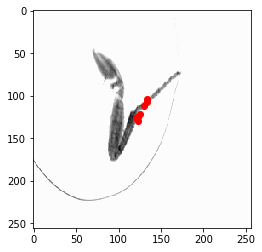

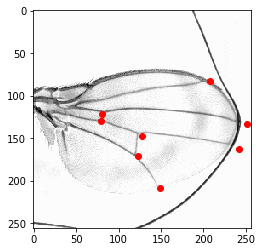

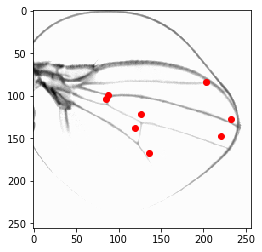

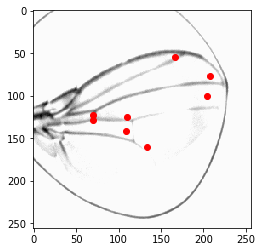

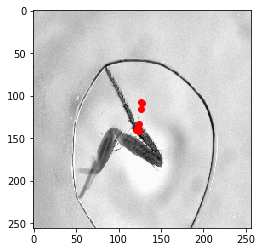

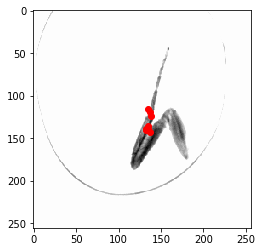

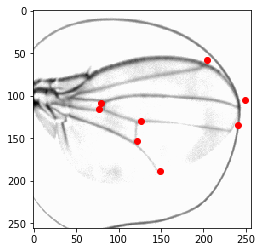

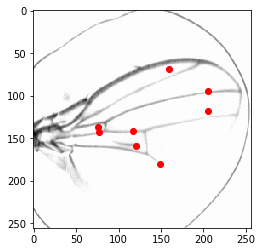

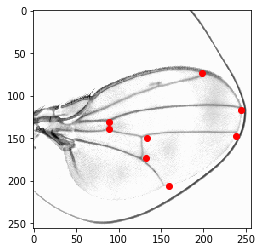

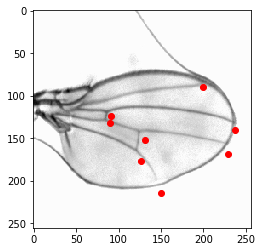

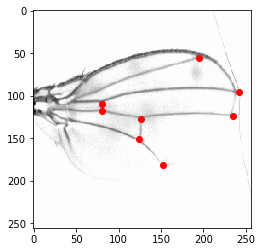

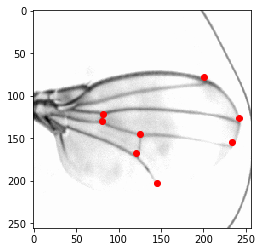

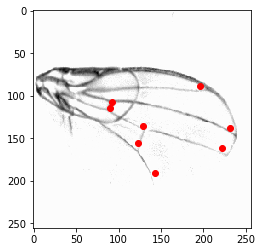

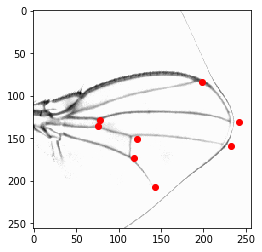

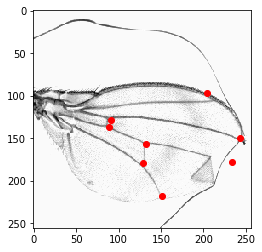

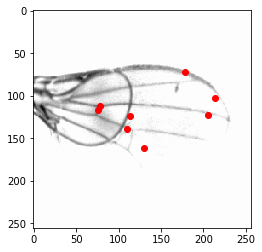

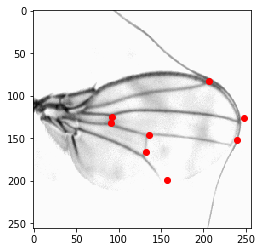

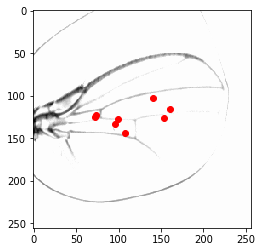

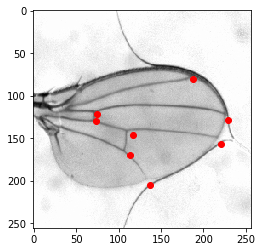

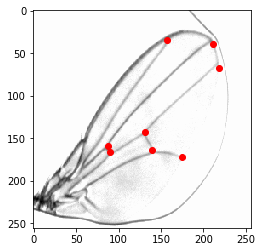

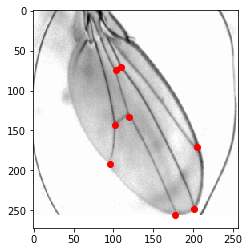

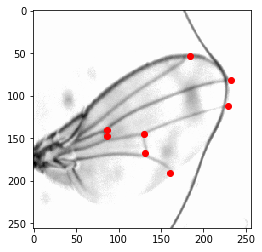

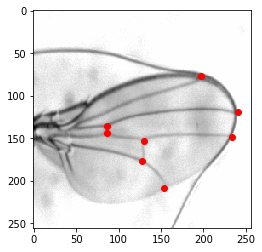

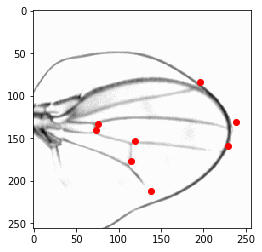

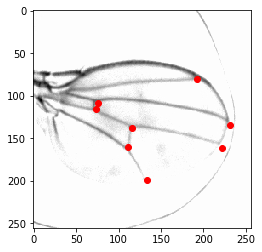

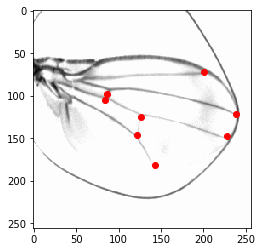

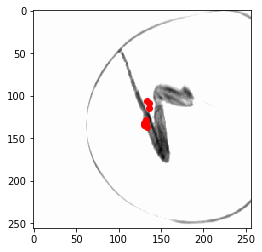

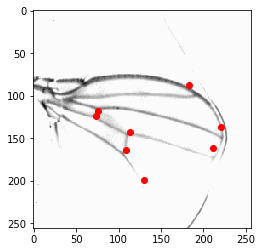

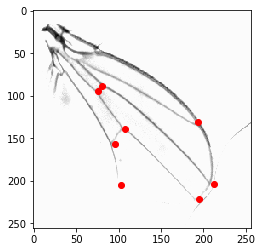

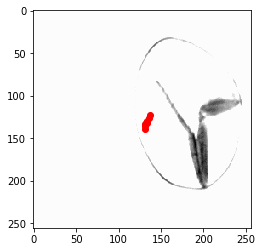

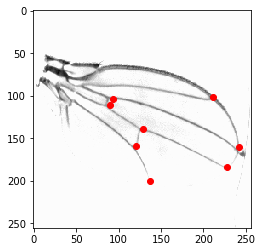

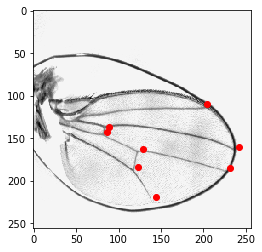

In [7]:
for i in range(0, BATCH_SIZE, 1):
    img_in = input_tensor[i][0].cpu().detach().numpy()
#     gt_pts = output_valid[i][0]
#     print("Shape est={}, gt={}".format(img_in.shape, img_in.shape))

#     f, axarr = plt.subplots(1,2)
    plt.figure()
    plt.imshow(img_in, cmap='gray')
    plt.scatter(output_valid[i][::2], output_valid[i][1::2], c='r')
#     plt.scatter(input_valid[i][::2], input_valid[i][1::2], c='b')
#     plt.scatter(input_valid[i][8], input_valid[i][9], c='b')
#     print(input_valid[i])
#     axarr[0].imshow(img_in, cmap='gray')